

# Creating generative diagrams for common datasets


In [1]:
!pip install diffusers

In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system

In [3]:
!pip install kaggle

## MNIST

In [4]:
from torchvision import transforms
from torchvision.datasets import MNIST



tf = transforms.Compose([transforms.ToTensor()]) # mnist is already normalised 0 to 1

dataset = MNIST("./data", train=True, download=True, transform=tf)


Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:00<00:00, 56.4MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.73MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:00<00:00, 12.5MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.73MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
from tqdm import tqdm

In [6]:
import numpy as np

In [7]:
import torch

In [8]:
def linear_schedule(num_timesteps):
  beta_start = 1e-4
  beta_end = 0.02
  betas = torch.linspace(beta_start, beta_end, num_timesteps)
  return betas

In [9]:
betas = linear_schedule(1000)

In [10]:
def alpha_mc(timesteps):
  betas = linear_schedule(timesteps)
  alphas = 1 - betas
  alphas_cumprod = torch.cumprod(alphas, axis=0)
  alphas_sqrt = torch.sqrt(alphas_cumprod)
  alphas_sqrt_minus = torch.sqrt(1 - alphas_cumprod)
  return alphas_sqrt, alphas_sqrt_minus

In [11]:
alphas_sqrt, alphas_sqrt_minus = alpha_mc(1000)

In [11]:
def generate_db(dataset,tim, alphas,alphas_minus):
  seeds = torch.randn_like(dataset).to(dataset.device)
  prop = alphas[tim]
  prop_noise = alphas_minus[tim]
  samples = dataset*prop + seeds*prop_noise
  return samples

In [11]:
!pip install pingouin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 4.4 MB/s eta 0:00:00


In [12]:
import pingouin as pg

In [13]:
def normality_test(dataset):
  mean = torch.mean(dataset, dim=0)
  cov = torch.cov(dataset.T)
  inv_cov = torch.inverse(cov)
  whitened_dataset = torch.matmul(dataset - mean, inv_cov)
  whit_flat = dataset.flatten()
  whit_flat_np = whit_flat.cpu().numpy()
  #arr = np.random.choice(whit_flat_np, 3000)

  res = normaltest(whit_flat_np)
  return res


In [14]:
from scipy.stats import chi2, kstest,normaltest


In [15]:
import torch

In [22]:
data_amp = torch.cat([dataset[i][0].view(1,784) for i in range(len(dataset))],dim=0)

In [23]:
timesteps = [i for i in range(300,850,50)]

svalues = []

for tim in tqdm(timesteps):
  samples = generate_db(data_amp.cuda(),tim,alphas_sqrt,alphas_sqrt_minus)
  statistics = normality_test(samples)
  print(statistics)
  svalues.append(statistics)

  9%|▉         | 1/11 [00:02<00:20,  2.07s/it]

NormaltestResult(statistic=7374.686286588719, pvalue=0.0)


 18%|█▊        | 2/11 [00:03<00:14,  1.65s/it]

NormaltestResult(statistic=1719.0661243218024, pvalue=0.0)


 27%|██▋       | 3/11 [00:04<00:12,  1.52s/it]

NormaltestResult(statistic=463.84100026302036, pvalue=1.897608218650825e-101)


 36%|███▋      | 4/11 [00:06<00:10,  1.45s/it]

NormaltestResult(statistic=90.03361337014474, pvalue=2.814811157040055e-20)


 45%|████▌     | 5/11 [00:07<00:08,  1.41s/it]

NormaltestResult(statistic=23.828351484475743, pvalue=6.694824838216396e-06)


 55%|█████▍    | 6/11 [00:08<00:06,  1.39s/it]

NormaltestResult(statistic=1.8217664045920838, pvalue=0.40216887066231316)


 64%|██████▎   | 7/11 [00:10<00:05,  1.38s/it]

NormaltestResult(statistic=3.7257310914255597, pvalue=0.15522718186079035)


 73%|███████▎  | 8/11 [00:11<00:04,  1.36s/it]

NormaltestResult(statistic=0.3829227589267513, pvalue=0.8257515154573131)


 82%|████████▏ | 9/11 [00:12<00:02,  1.36s/it]

NormaltestResult(statistic=0.41810358672876746, pvalue=0.811353211842599)


 91%|█████████ | 10/11 [00:14<00:01,  1.36s/it]

NormaltestResult(statistic=5.1642872997260865, pvalue=0.07561174506483109)


100%|██████████| 11/11 [00:15<00:00,  1.43s/it]

NormaltestResult(statistic=2.6084208098079777, pvalue=0.2713867361043688)


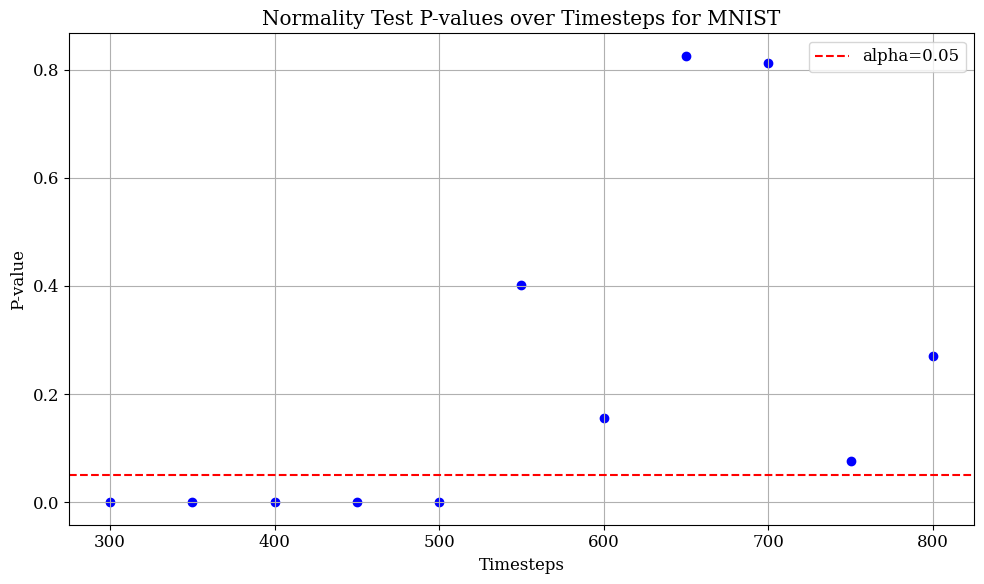

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming your data is in 'svalues' and 'timesteps'

# Create the plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed

# Extract p-values from svalues (assuming it's a list of scipy.stats.normaltest results)
p_values = [result.pvalue for result in svalues]

# Plot the p-values against timesteps
plt.scatter(timesteps, p_values, marker='o', linestyle='-', color='b')

# Customize the plot
plt.xlabel("Timesteps")
plt.ylabel("P-value")
plt.title("Normality Test P-values over Timesteps for MNIST")

# Apply ICML-like style elements
plt.tight_layout()
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12
plt.grid(True)  # Add a grid

# Optionally, add a horizontal line at alpha=0.05 for significance
plt.axhline(y=0.05, color='r', linestyle='--', label='alpha=0.05')
plt.legend()

# Display the plot
plt.savefig("mnist_normality_test.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Create Generative Diagram

In [12]:
label_list = [0,1,2,3,4,5,6,7,8,9]

In [13]:
from tqdm import tqdm

In [14]:
dataset_by_class = {}
for label in label_list:
  dataset_by_class[label] = []


for i in tqdm(range(len(dataset))):
  dataset_by_class[dataset[i][1]].append(dataset[i][0])


100%|██████████| 60000/60000 [00:12<00:00, 4847.43it/s]


In [ ]:
self_correlation_dicts = {}
mean_dicts = {}
for label in tqdm(label_list):
  data = torch.cat([img.unsqueeze(0) for img in dataset_by_class[label]])
  data = data.view(-1, 784)
  self_correlation_dicts[label] = torch.cov(data.T)




100%|██████████| 10/10 [00:00<00:00, 11.37it/s]


In [16]:
def linear_schedule(num_timesteps):
  beta_start = 1e-4
  beta_end = 0.02
  betas = torch.linspace(beta_start, beta_end, num_timesteps)
  return betas

In [17]:
betas = linear_schedule(1000)

In [18]:
def intg_lin_sched(beta_start,beta_end,num_timesteps,t):
  return beta_start*t + 0.5*(beta_end - beta_start) * t*t / num_timesteps

In [19]:
from functools import partial

In [20]:
intg_lin_sched_partial = partial(intg_lin_sched, 1e-4, 0.02, 1000)

In [21]:
def J_t(timestep):
  return np.exp(0.5*-intg_lin_sched_partial(timestep))

In [22]:
import torch
from torch.autograd import Function
import numpy as np
import scipy.linalg


class MatrixSquareRoot(Function):
    """Square root of a positive definite matrix.

    NOTE: matrix square root is not differentiable for matrices with
          zero eigenvalues.
    """
    @staticmethod
    def forward(ctx, input):
        m = input.detach().cpu().numpy().astype(np.float_)
        sqrtm = torch.from_numpy(scipy.linalg.sqrtm(m).real).to(input)
        ctx.save_for_backward(sqrtm)
        return sqrtm

    @staticmethod
    def backward(ctx, grad_output):
        grad_input = None
        if ctx.needs_input_grad[0]:
            sqrtm, = ctx.saved_tensors
            sqrtm = sqrtm.data.cpu().numpy().astype(np.float_)
            gm = grad_output.data.cpu().numpy().astype(np.float_)

            # Given a positive semi-definite matrix X,
            # since X = X^{1/2}X^{1/2}, we can compute the gradient of the
            # matrix square root dX^{1/2} by solving the Sylvester equation:
            # dX = (d(X^{1/2})X^{1/2} + X^{1/2}(dX^{1/2}).
            grad_sqrtm = scipy.linalg.solve_sylvester(sqrtm, sqrtm, gm)

            grad_input = torch.from_numpy(grad_sqrtm).to(grad_output)
        return grad_input


sqrtm = MatrixSquareRoot.apply

In [23]:
import math

In [24]:
def eye_like(tensor):
    return torch.eye(tensor.shape[0])

In [25]:
def pr_eigenvectors(dataset):
  dct = {}
  for label in tqdm(label_list):
    _,S,_ = torch.linalg.svd(dataset[label])

    # Step 2: Find the index of the largest eigenvalue
    # Eigenvalues are complex, so we need to take the real part for comparison
    real_eigenvalues = S.real

    max_eig = torch.max(real_eigenvalues)

    # Step 3: The eigenvector corresponding to the largest eigenvalue
    dct[label] = max_eig

  return dct



In [26]:
self_correlation_dicts.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [27]:
values_dct = {}

eigs = pr_eigenvectors(self_correlation_dicts)

for label in tqdm(eigs.keys()):
  vls = []
  for t in range(0,700,50):
    val_t = J_t(t)*J_t(t)*eigs[label] + (1-J_t(t)*J_t(t))
    vls.append(val_t)
  values_dct[label] = vls


100%|██████████| 10/10 [00:00<00:00, 2695.05it/s]


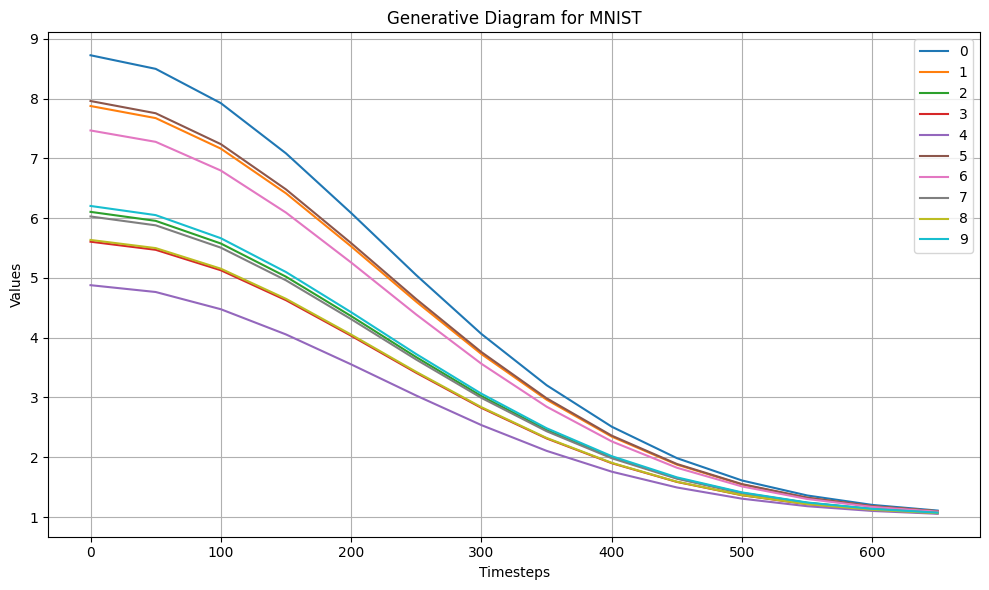

In [28]:
import matplotlib.pyplot as plt

# Assuming your data is in values_dct

# Define timesteps
timesteps = list(range(0, 700, 50))

# Create the plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed

# Plot each class's data
for label, values in values_dct.items():
    plt.plot(timesteps, np.array([val.item() for val in values]), label=label)  # Label each line

# Customize the plot
plt.xlabel("Timesteps")
plt.ylabel("Values")
plt.title("Generative Diagram for MNIST")
plt.legend()  # Show the legend with class names

# Apply ICML-like style elements
plt.tight_layout()
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12
plt.grid(True)  # Add a grid

# Display the plot
plt.savefig("mnist_gen_diag.pdf", format="pdf", bbox_inches="tight")

plt.show()


## CIFAR 10

###Test on mixing  time.



In [57]:
from datasets import load_dataset

dataset_name = "uoft-cs/cifar10"
dataset = load_dataset(dataset_name, split="train")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.16k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/120M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/23.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

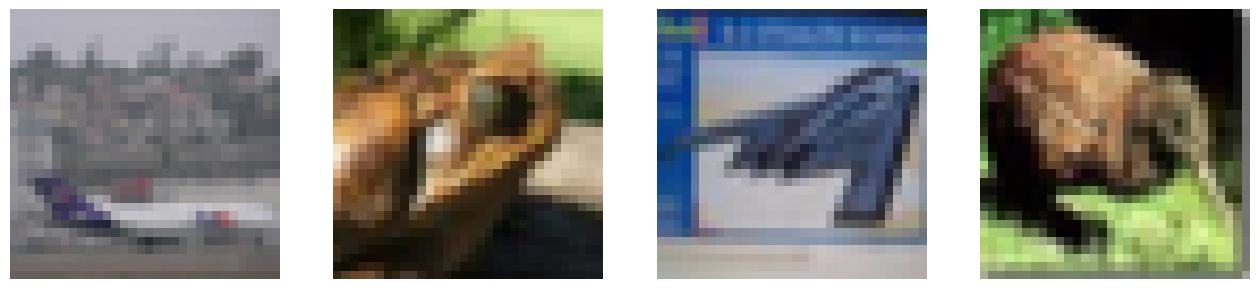

In [58]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["img"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

In [59]:
from torchvision import transforms

preprocess = transforms.Compose(
    [
        transforms.Resize((32,32)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

In [60]:
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["img"]]
    return {"images": images}


dataset.set_transform(transform)

In [61]:
from tqdm import tqdm

In [62]:
import numpy as np

In [63]:
import torch

In [64]:
def linear_schedule(num_timesteps):
  beta_start = 1e-4
  beta_end = 0.02
  betas = torch.linspace(beta_start, beta_end, num_timesteps)
  return betas

In [65]:
betas = linear_schedule(1000)

In [66]:
def alpha_mc(timesteps):
  betas = linear_schedule(timesteps)
  alphas = 1 - betas
  alphas_cumprod = torch.cumprod(alphas, axis=0)
  alphas_sqrt = torch.sqrt(alphas_cumprod)
  alphas_sqrt_minus = torch.sqrt(1 - alphas_cumprod)
  return alphas_sqrt, alphas_sqrt_minus

In [67]:
alphas_sqrt, alphas_sqrt_minus = alpha_mc(1000)

In [68]:
def generate_db(dataset,tim, alphas,alphas_minus):
  seeds = torch.randn_like(dataset).to(dataset.device)
  prop = alphas[tim]
  prop_noise = alphas_minus[tim]
  samples = dataset*prop + seeds*prop_noise
  return samples

In [ ]:
!pip install pingouin

In [ ]:
import pingouin as pg

In [ ]:
def normality_test(dataset):
  mean = torch.mean(dataset, dim=0)
  cov = torch.cov(dataset.T)
  inv_cov = torch.inverse(cov)
  whitened_dataset = torch.matmul(dataset - mean, inv_cov)
  whit_flat = dataset.flatten()
  whit_flat_np = whit_flat.cpu().numpy()
  #arr = np.random.choice(whit_flat_np, 3000)

  res = normaltest(whit_flat_np)
  return res


In [ ]:
from scipy.stats import chi2, kstest,normaltest


In [ ]:
import torch

In [ ]:
data_amp = torch.randn((50000,3072))

In [ ]:
for i in range(len(data_amp)):
  data_amp[i] = dataset[i]["images"].flatten()

In [ ]:
timesteps = [i for i in range(300,850,50)]

svalues = []

for tim in tqdm(timesteps):
  samples = generate_db(data_amp.cuda(),tim,alphas_sqrt,alphas_sqrt_minus)
  statistics = normality_test(samples)
  print(statistics)
  svalues.append(statistics)

  9%|▉         | 1/11 [00:04<00:43,  4.36s/it]

NormaltestResult(statistic=5263.339069135338, pvalue=0.0)


 18%|█▊        | 2/11 [00:08<00:39,  4.35s/it]

NormaltestResult(statistic=1277.268525948127, pvalue=4.412285804894984e-278)


 27%|██▋       | 3/11 [00:13<00:34,  4.36s/it]

NormaltestResult(statistic=258.6307374350062, pvalue=6.903175914401212e-57)


 36%|███▋      | 4/11 [00:17<00:30,  4.36s/it]

NormaltestResult(statistic=72.96889929353132, pvalue=1.4289098932324161e-16)


 45%|████▌     | 5/11 [00:21<00:26,  4.38s/it]

NormaltestResult(statistic=15.87550153991928, pvalue=0.0003570085703251933)


 55%|█████▍    | 6/11 [00:26<00:21,  4.37s/it]

NormaltestResult(statistic=5.064719584988384, pvalue=0.07947126314880312)


 64%|██████▎   | 7/11 [00:30<00:17,  4.37s/it]

NormaltestResult(statistic=0.11668278905525234, pvalue=0.9433278454937976)


 73%|███████▎  | 8/11 [00:34<00:13,  4.36s/it]

NormaltestResult(statistic=2.4265879735505758, pvalue=0.2972166375324313)


 82%|████████▏ | 9/11 [00:39<00:08,  4.37s/it]

NormaltestResult(statistic=0.23030007084267204, pvalue=0.8912324174439695)


 91%|█████████ | 10/11 [00:43<00:04,  4.37s/it]

NormaltestResult(statistic=2.9967350933532715, pvalue=0.22349470719196635)


100%|██████████| 11/11 [00:48<00:00,  4.37s/it]

NormaltestResult(statistic=1.3306025831870973, pvalue=0.5141186047556128)


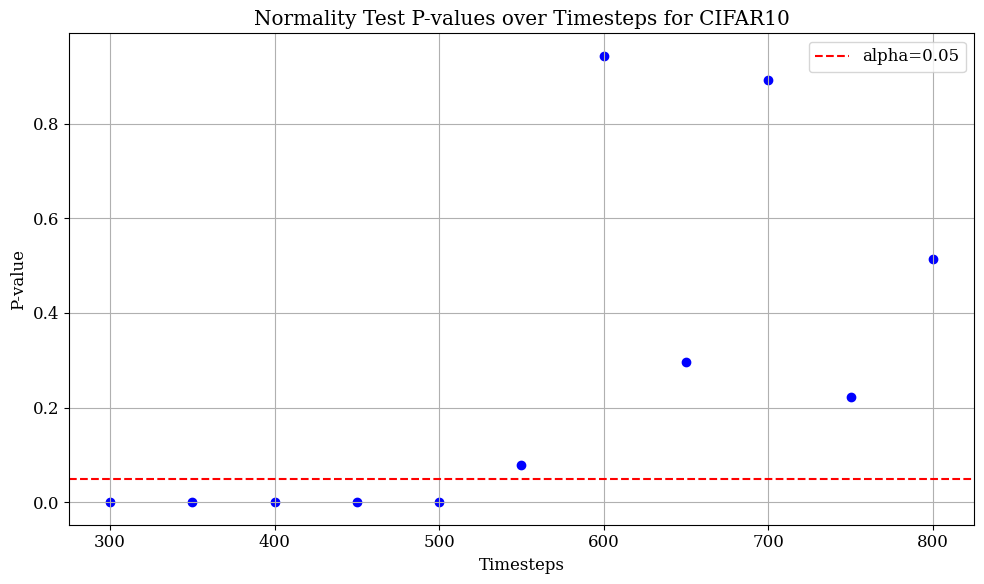

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming your data is in 'svalues' and 'timesteps'

# Create the plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed

# Extract p-values from svalues (assuming it's a list of scipy.stats.normaltest results)
p_values = [result.pvalue for result in svalues]

# Plot the p-values against timesteps
plt.scatter(timesteps, p_values, marker='o', linestyle='-', color='b')

# Customize the plot
plt.xlabel("Timesteps")
plt.ylabel("P-value")
plt.title("Normality Test P-values over Timesteps for CIFAR10")

# Apply ICML-like style elements
plt.tight_layout()
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12
plt.grid(True)  # Add a grid

# Optionally, add a horizontal line at alpha=0.05 for significance
plt.axhline(y=0.05, color='r', linestyle='--', label='alpha=0.05')
plt.legend()

# Display the plot
plt.savefig("cifar10_normality_test.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Create Generative Diagram

In [69]:
from datasets import load_dataset

dataset_name = "uoft-cs/cifar10"
dataset = load_dataset(dataset_name, split="train")

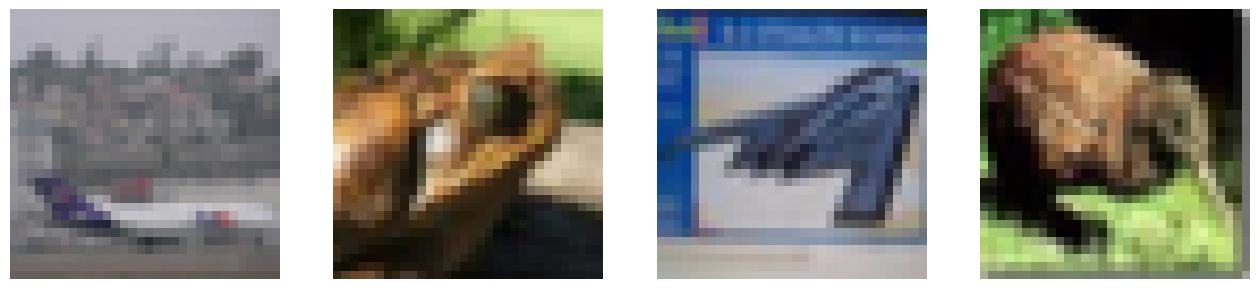

In [70]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["img"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

In [71]:
label_list = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [72]:
from torchvision import transforms

preprocess = transforms.Compose(
    [
        transforms.Resize((32,32)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

In [73]:
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["img"]]
    labels = [label_list[label] for label in examples["label"]]
    return {"images": images, "labels":labels}


dataset.set_transform(transform)

In [74]:
dataset[0]["labels"]

'airplane'

In [75]:
def dataset_by_class(dataset, class_name):
    return dataset.filter(lambda x: x["labels"] == class_name)

In [76]:
def dataset_by_class(dataset, class_name):
    return dataset.filter(lambda x: x["labels"] == class_name)

In [77]:
dataset_classes_dict = dict(zip(label_list, [dataset_by_class(dataset, label) for label in label_list]))

Filter:   0%|          | 0/50000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/50000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/50000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/50000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/50000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/50000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/50000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/50000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/50000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
dataset_classes_dict['airplane'][0]

{'images': tensor([[[ 0.3961,  0.3961,  0.3961,  ...,  0.3333,  0.3176,  0.2941],
          [ 0.4118,  0.4039,  0.4118,  ...,  0.3569,  0.3412,  0.3176],
          [ 0.3882,  0.3882,  0.3961,  ...,  0.3412,  0.3255,  0.3098],
          ...,
          [-0.1216, -0.1137, -0.1059,  ..., -0.2157, -0.2314, -0.2078],
          [-0.1216, -0.1216, -0.1137,  ..., -0.2000, -0.2000, -0.2000],
          [-0.1922, -0.2157, -0.1922,  ..., -0.2784, -0.2706, -0.2863]],
 
         [[ 0.3804,  0.3804,  0.3804,  ...,  0.3176,  0.3020,  0.2784],
          [ 0.3961,  0.3882,  0.3961,  ...,  0.3412,  0.3255,  0.3020],
          [ 0.3725,  0.3725,  0.3804,  ...,  0.3255,  0.3098,  0.2941],
          ...,
          [-0.1608, -0.1451, -0.1373,  ..., -0.2392, -0.2627, -0.2549],
          [-0.2000, -0.1922, -0.1922,  ..., -0.2549, -0.2706, -0.2784],
          [-0.2471, -0.2706, -0.2549,  ..., -0.3412, -0.3255, -0.3412]],
 
         [[ 0.4824,  0.4824,  0.4824,  ...,  0.4118,  0.3882,  0.3647],
          [ 0.4980

In [78]:
from tqdm import tqdm

In [79]:
dataset_images_dict = {}
for label in tqdm(label_list):
  im_arr = []
  j = len(dataset_classes_dict[label])
  for i in range(j):
    im_arr.append(dataset_classes_dict[label][i]["images"])
  dataset_images_dict[label] = im_arr


100%|██████████| 10/10 [00:28<00:00,  2.85s/it]


In [80]:
import numpy as np

In [81]:
import torch

In [82]:
self_correlation_dicts = {}
mean_dicts = {}
for label in tqdm(label_list):
  data = torch.cat([img.unsqueeze(0) for img in dataset_images_dict[label]])
  data = data.view(-1,3*32*32)
  self_correlation_dicts[label] = torch.cov(data.T)
  mean_dicts[label] = torch.mean(data,dim=0)




100%|██████████| 10/10 [00:02<00:00,  3.83it/s]


In [ ]:
self_correlation_dicts['airplane']

tensor([[0.2899, 0.2833, 0.2789,  ..., 0.0597, 0.0612, 0.0646],
        [0.2833, 0.2840, 0.2809,  ..., 0.0566, 0.0579, 0.0604],
        [0.2789, 0.2809, 0.2833,  ..., 0.0549, 0.0556, 0.0577],
        ...,
        [0.0597, 0.0566, 0.0549,  ..., 0.3117, 0.3084, 0.3034],
        [0.0612, 0.0579, 0.0556,  ..., 0.3084, 0.3120, 0.3094],
        [0.0646, 0.0604, 0.0577,  ..., 0.3034, 0.3094, 0.3157]])

In [ ]:
self_correlation_dicts['airplane'].shape

torch.Size([3072, 3072])

In [83]:
def linear_schedule(num_timesteps):
  beta_start = 1e-4
  beta_end = 0.02
  betas = torch.linspace(beta_start, beta_end, num_timesteps)
  return betas

In [84]:
betas = linear_schedule(1000)

In [85]:
def intg_lin_sched(beta_start,beta_end,num_timesteps,t):
  return beta_start*t + 0.5*(beta_end - beta_start) * t*t / num_timesteps

In [86]:
from functools import partial

In [87]:
intg_lin_sched_partial = partial(intg_lin_sched, 1e-4, 0.02, 1000)

In [89]:
def J_t(timestep):
  return np.exp(0.5*-intg_lin_sched_partial(timestep))

In [90]:
import math

In [91]:
def eye_like(tensor):
    return torch.eye(tensor.shape[0])

In [ ]:
def pr_eigenvectors(dataset):
  dct = {}
  for label in tqdm(label_list):
    _,S,_ = torch.linalg.svd(dataset[label])

    # Step 2: Find the index of the largest eigenvalue
    # Eigenvalues are complex, so we need to take the real part for comparison
    real_eigenvalues = S.real

    max_eig = torch.max(real_eigenvalues)

    # Step 3: The eigenvector corresponding to the largest eigenvalue
    dct[label] = max_eig

  return dct



In [ ]:
self_correlation_dicts.keys()

dict_keys(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

In [ ]:
label_list

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
self_correlation_dicts['airplane']

In [ ]:
_,S,_= torch.linalg.svd(self_correlation_dicts['airplane'])




In [ ]:
torch.max(S)

tensor(260.6290)

In [ ]:
values_dct = {}

eigs = pr_eigenvectors(self_correlation_dicts)

for label in tqdm(eigs.keys()):
  vls = []
  for t in range(0,700,50):
    val_t = J_t(t)*J_t(t)*eigs[label] + (1-J_t(t)*J_t(t))
    vls.append(val_t)
  values_dct[label] = vls


100%|██████████| 10/10 [00:00<00:00, 1748.94it/s]


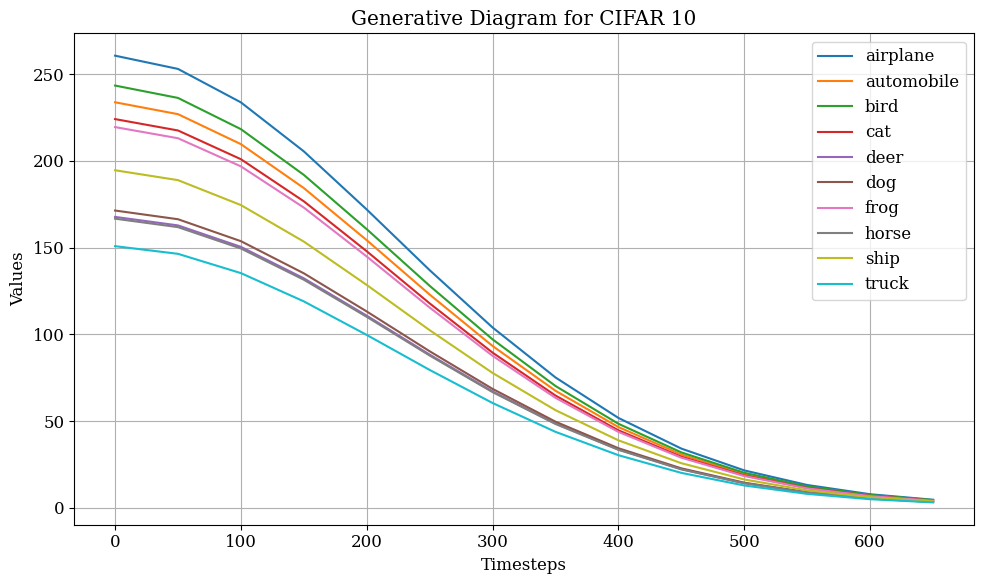

In [ ]:
import matplotlib.pyplot as plt

# Assuming your data is in values_dct

# Define timesteps
timesteps = list(range(0, 700, 50))

# Create the plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed

# Plot each class's data
for label, values in values_dct.items():
    plt.plot(timesteps, np.array([val.item() for val in values]), label=label)  # Label each line

# Customize the plot
plt.xlabel("Timesteps")
plt.ylabel("Values")
plt.title("Generative Diagram for CIFAR 10")
plt.legend()  # Show the legend with class names

# Apply ICML-like style elements
plt.tight_layout()
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12
plt.grid(True)  # Add a grid

# Display the plot
plt.savefig("cifar10_gen_diag.pdf", format="pdf", bbox_inches="tight")

plt.show()


## Imagenet Subsets - SD Latent Space

To make things easier we load from a dataset of already stored latents https://github.com/cloneofsimo/imagenet.int8

In [49]:
# Pro tip : use `hf_transfer` to get faster download speed.
!pip install hf_transfer
!export HF_HUB_ENABLE_HF_TRANSFER=True
# actual download script.
!huggingface-cli download --repo-type dataset cloneofsimo/imagenet.int8 --local-dir ./vae_mds

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 33.7 MB/s eta 0:00:00
Fetching 133 files:   0% 0/133 [00:00<?, ?it/s]Downloading 'shard.0001.mds' to 'vae_mds/.cache/huggingface/download/shard.0001.mds.9084853d74d30cbc2ff25193dbd955405872323bcdf1e127b767086e41534a72.incomplete'

.gitattributes: 100% 8.89k/8.89k [00:00<00:00, 38.8MB/s]
Download complete. Moving file to vae_mds/.gitattributes
Fetching 133 files:   1% 1/133 [00:00<01:03,  2.08it/s]
shard.0003.mds:   0% 0.00/15.6M [00:00<?, ?B/s]Downloading 'shard.0002.mds' to 'vae_mds/.cache/huggingface/download/shard.0002.mds.37578b0e28f12868618d82b210508f6845c0c3dbd21b15e78e885fc7c5f15f36.incomplete'


shard.0001.mds:   0% 0.00/15.6M [00:00<?, ?B/s]


vae.png:   0% 0.00/3.38M [00:00<?, ?B/s]Downloading 'shard.0004.mds' to 'vae_mds/.cache/huggingface/download/shard.0004.mds.629123eaba5834069a276f8546bff1ae46d13eae6501a1d1816c2d3676f7f447.incomplete'




shard.0000.mds:   0% 0.00/67.1M [00:00<?, ?B/s]




README.md: 100% 5.16k/5.16k

In [50]:
!pip install mosaicml-streaming

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.6/80.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.9/263.9 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.6/187.6 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.6/408.6 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.4/258.4 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 70.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.6/114.6 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.7/28.7 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 86.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:

from streaming.base.format.mds.encodings import Encoding, _encodings
import numpy as np
from typing import Any
import torch
from streaming import StreamingDataset

class uint8(Encoding):
    def encode(self, obj: Any) -> bytes:
        return obj.tobytes()

    def decode(self, data: bytes) -> Any:
        x=  np.frombuffer(data, np.uint8).astype(np.float32)
        return (x / 255.0 - 0.5) * 24.0

_encodings["uint8"] = uint8

remote_train_dir = "./vae_mds" # this is the path you installed this dataset.
local_train_dir = "/content/train_dir"

train_dataset = StreamingDataset(
    local=local_train_dir,
    remote=remote_train_dir,
    split=None,
    shuffle=True,
    shuffle_algo="naive",
    num_canonical_nodes=1,
    batch_size = 32
)

In [2]:
len(train_dataset)

1281167

In [3]:
train_dataset[0]

{'label': '726',
 'label_as_text': "plane, carpenter's plane, woodworking plane",
 'vae_output': array([ 2.8705888 ,  1.3647065 , -0.79999995, ..., -5.1294117 ,
        -1.4588234 , -2.9647057 ], dtype=float32)}

### Mixing Time

In [4]:
from tqdm import tqdm

In [5]:
data_amp = []

for i in tqdm(range(len(train_dataset))):
  data_amp.append(torch.from_numpy(train_dataset[i]["vae_output"]).view(1,4096))

100%|██████████| 1281167/1281167 [02:03<00:00, 10358.55it/s]


In [6]:
def linear_schedule(num_timesteps):
  beta_start = 1e-4
  beta_end = 0.02
  betas = torch.linspace(beta_start, beta_end, num_timesteps)
  return betas

In [7]:
betas = linear_schedule(1000)

In [8]:
def alpha_mc(timesteps):
  betas = linear_schedule(timesteps)
  alphas = 1 - betas
  alphas_cumprod = torch.cumprod(alphas, axis=0)
  alphas_sqrt = torch.sqrt(alphas_cumprod)
  alphas_sqrt_minus = torch.sqrt(1 - alphas_cumprod)
  return alphas_sqrt, alphas_sqrt_minus

In [9]:
alphas_sqrt, alphas_sqrt_minus = alpha_mc(1000)

In [10]:
def generate_db(dataset,tim, alphas,alphas_minus):
  seeds = torch.randn_like(dataset).to(dataset.device)
  prop = alphas[tim]
  prop_noise = alphas_minus[tim]
  samples = dataset*prop + seeds*prop_noise
  return samples

In [11]:
!pip install pingouin

In [12]:
import pingouin as pg

In [13]:
def normality_test(dataset):
  mean = torch.mean(dataset, dim=0)
  cov = torch.cov(dataset.T)
  inv_cov = torch.inverse(cov)
  whitened_dataset = torch.matmul(dataset - mean, inv_cov)
  whit_flat = dataset.flatten()
  whit_flat_np = whit_flat.cpu().numpy()
  #arr = np.random.choice(whit_flat_np, 3000)

  res = normaltest(whit_flat_np)
  return res


In [14]:
from scipy.stats import chi2, kstest,normaltest


In [16]:
data_amp = torch.cat(data_amp)

In [18]:
perm = torch.randperm(data_amp.size(0))
k = 50000 #For T4 GPU this suffices otherwise can increase
idx = perm[:k]
samples = data_amp[idx]



In [21]:
timesteps = [i for i in range(300,850,50)]

svalues = []

for tim in tqdm(timesteps):
  samples_2 = generate_db(samples.cuda(),tim,alphas_sqrt,alphas_sqrt_minus)
  statistics = normality_test(samples_2)
  print(statistics)
  svalues.append(statistics)

  9%|▉         | 1/11 [00:04<00:47,  4.71s/it]

NormaltestResult(statistic=222677.1246968927, pvalue=0.0)


 18%|█▊        | 2/11 [00:09<00:42,  4.69s/it]

NormaltestResult(statistic=115413.13175995678, pvalue=0.0)


 27%|██▋       | 3/11 [00:14<00:37,  4.68s/it]

NormaltestResult(statistic=47802.553870272364, pvalue=0.0)


 36%|███▋      | 4/11 [00:18<00:32,  4.70s/it]

NormaltestResult(statistic=15082.191737773865, pvalue=0.0)


 45%|████▌     | 5/11 [00:23<00:28,  4.69s/it]

NormaltestResult(statistic=3585.1920934896816, pvalue=0.0)


 55%|█████▍    | 6/11 [00:28<00:23,  4.66s/it]

NormaltestResult(statistic=684.2579641670055, pvalue=2.601782462430331e-149)


 64%|██████▎   | 7/11 [00:32<00:18,  4.64s/it]

NormaltestResult(statistic=101.20087987690039, pvalue=1.0580547782917309e-22)


 73%|███████▎  | 8/11 [00:37<00:13,  4.66s/it]

NormaltestResult(statistic=3.0965991162784965, pvalue=0.2126091961980788)


 82%|████████▏ | 9/11 [00:42<00:09,  4.68s/it]

NormaltestResult(statistic=0.45286822435558466, pvalue=0.7973718776787576)


 91%|█████████ | 10/11 [00:46<00:04,  4.71s/it]

NormaltestResult(statistic=3.8057514410137165, pvalue=0.1491391195336742)


100%|██████████| 11/11 [00:51<00:00,  4.69s/it]

NormaltestResult(statistic=0.49124764168845514, pvalue=0.7822164231000706)


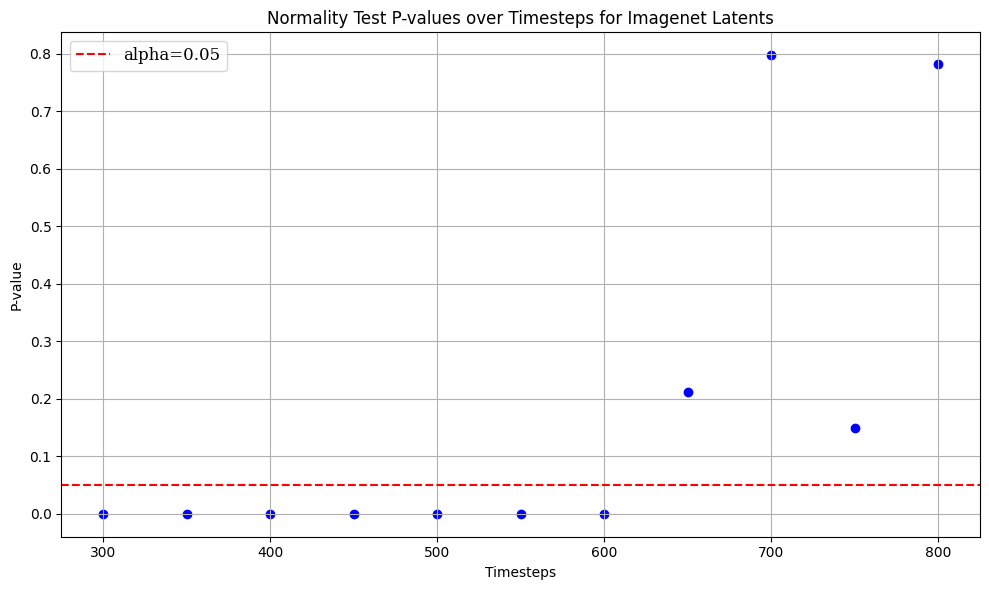

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming your data is in 'svalues' and 'timesteps'

# Create the plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed

# Extract p-values from svalues (assuming it's a list of scipy.stats.normaltest results)
p_values = [result.pvalue for result in svalues]

# Plot the p-values against timesteps
plt.scatter(timesteps, p_values, marker='o', linestyle='-', color='b')

# Customize the plot
plt.xlabel("Timesteps")
plt.ylabel("P-value")
plt.title("Normality Test P-values over Timesteps for Imagenet Latents")

# Apply ICML-like style elements
plt.tight_layout()
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12
plt.grid(True)  # Add a grid

# Optionally, add a horizontal line at alpha=0.05 for significance
plt.axhline(y=0.05, color='r', linestyle='--', label='alpha=0.05')
plt.legend()

# Display the plot
plt.savefig("imagenet_latents_normality_test.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Generative Diagram

In [4]:
label_list = [i for i in range(1000)]
dataset_images_dict = {}
for label in label_list:
  dataset_images_dict[label] = []





https://gist.github.com/aaronpolhamus/964a4411c0906315deb9f4a3723aac57#file-map_clsloc-txt find class number to label mappings here

In [5]:
with open('map_clsloc.txt', 'r') as file:
    file_content = file.readlines()

In [6]:
file_content[0]

'n02119789 1 kit_fox\n'

In [7]:
import re

def convert_to_dict(input_string_list):
  """Converts a string to a dictionary with specific formatting.

  Args:
    input_string: The input string in the format 'n[number] [key] [value]\n'.

  Returns:
    A dictionary with the extracted key and value.
  """

  # Use regular expression to extract key and value
  dct = {}

  for input_string in input_string_list:
    match = re.search(r'n\d+ (\d+) (.*)\n', input_string)
    if match:
      key = int(match.group(1))-1  # Convert key to integer
      value = match.group(2)
      dct[key] = value
  return dct


In [8]:
label_names = convert_to_dict(file_content)

In [9]:
from tqdm import tqdm

In [10]:
for i in tqdm(range(len(train_dataset))):
  label = int(train_dataset[i]["label"])
  dataset_images_dict[label].append(torch.from_numpy(train_dataset[i]["vae_output"]).unsqueeze(0))

100%|██████████| 1281167/1281167 [03:32<00:00, 6039.00it/s]


In [11]:
import numpy as np

In [12]:
import torch

In [13]:
import random

In [14]:
label_samples = random.sample(label_list,100)

In [15]:
self_correlation_dicts = {}
for label in tqdm(label_samples):
  data = torch.cat([lat for lat in dataset_images_dict[label]],dim=0)
  self_correlation_dicts[label_names[label]] = torch.cov(data.T)




100%|██████████| 100/100 [00:19<00:00,  5.08it/s]


In [16]:
def linear_schedule(num_timesteps):
  beta_start = 1e-4
  beta_end = 0.02
  betas = torch.linspace(beta_start, beta_end, num_timesteps)
  return betas

In [17]:
betas = linear_schedule(1000)

In [18]:
def intg_lin_sched(beta_start,beta_end,num_timesteps,t):
  return beta_start*t + 0.5*(beta_end - beta_start) * t*t / num_timesteps

In [19]:
from functools import partial

In [20]:
intg_lin_sched_partial = partial(intg_lin_sched, 1e-4, 0.02, 1000)

In [21]:
def J_t(timestep):
  return np.exp(-intg_lin_sched_partial(timestep))

In [22]:
import math

In [23]:
def eye_like(tensor):
    return torch.eye(tensor.shape[0])

In [ ]:
def pr_eigenvectors(dataset):
  dct = {}
  for label in tqdm(dataset.keys()):
    _,S,_ = torch.linalg.svd(dataset[label])

    real_eigenvalues = S.real

    max_eig = torch.max(real_eigenvalues)

    dct[label] = max_eig

  return dct



In [25]:
self_correlation_dicts.keys()

dict_keys(['wallaby', 'tarantula', 'bulletproof_vest', 'Doberman', 'butternut_squash', 'perfume', 'modem', 'espresso', 'projectile', 'gondola', 'ant', 'zebra', 'pickup', 'conch', 'chow', 'drake', 'magnetic_compass', 'obelisk', 'artichoke', 'mongoose', 'West_Highland_white_terrier', 'Bernese_mountain_dog', 'microwave', 'eft', 'redbone', 'puffer', 'acorn_squash', 'wing', 'maillot', 'grocery_store', 'ballplayer', 'snorkel', 'plow', 'accordion', 'bannister', 'holster', 'oxcart', 'Greater_Swiss_Mountain_dog', 'entertainment_center', 'canoe', 'bullfrog', 'sandbar', 'hen', 'photocopier', 'pickelhaube', 'horse_cart', 'gar', 'Petri_dish', 'crane', 'kuvasz', 'diaper', 'German_shepherd', 'weasel', 'grasshopper', 'suspension_bridge', 'coral_reef', 'king_crab', 'monarch', 'meerkat', 'suit', 'king_snake', 'coho', 'Dungeness_crab', 'traffic_light', 'velvet', 'toilet_seat', 'fly', 'beagle', 'junco', 'partridge', 'red-backed_sandpiper', 'boa_constrictor', 'clog', 'volleyball', 'scorpion', 'coucal', 'ga

In [ ]:
values_dct = {}

eigs = pr_eigenvectors(self_correlation_dicts)

for label in tqdm(eigs.keys()):
  vls = []
  for t in range(0,700,50):
    val_t = J_t(t)*J_t(t)*eigs[label] + (1-J_t(t)*J_t(t))
    vls.append(val_t)
  values_dct[label] = vls


100%|██████████| 100/100 [00:00<00:00, 3323.54it/s]


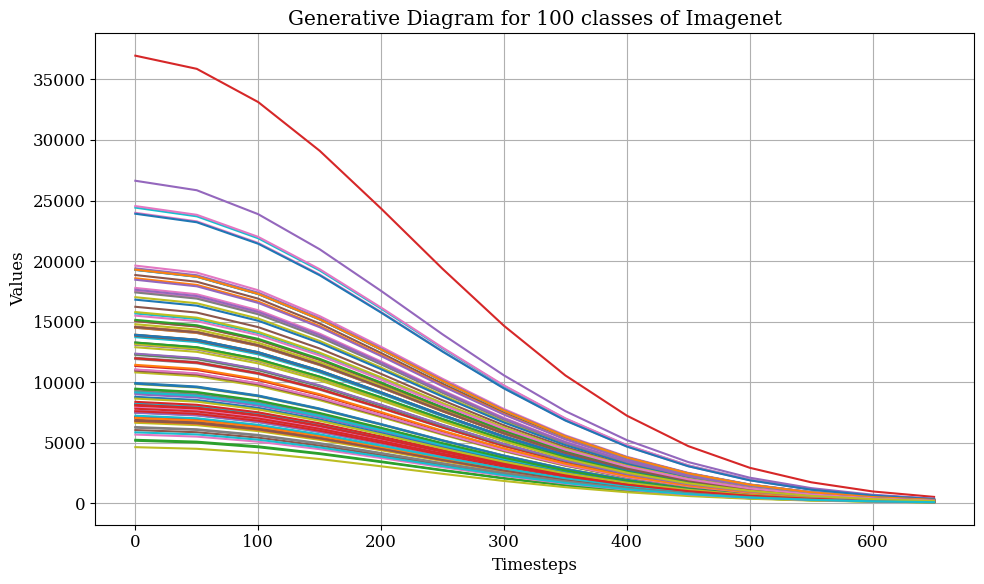

In [33]:
import matplotlib.pyplot as plt

# Assuming your data is in values_dct

# Define timesteps
timesteps = list(range(0, 700, 50))

# Create the plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed

# Plot each class's data
for label, values in values_dct.items():
    plt.plot(timesteps, np.array([val.item() for val in values]), label=label)  # Label each line

# Customize the plot
plt.xlabel("Timesteps")
plt.ylabel("Values")
plt.title("Generative Diagram for 100 classes of Imagenet")
#plt.legend(fontsize='small',ncol=5)  # Show the legend with class names

# Apply ICML-like style elements
plt.tight_layout()
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12
plt.grid(True)  # Add a grid

# Display the plot
plt.savefig("imagenet_100_gen_diag.pdf", format="pdf", bbox_inches="tight")

plt.show()


In [36]:
list_labels = values_dct.keys()

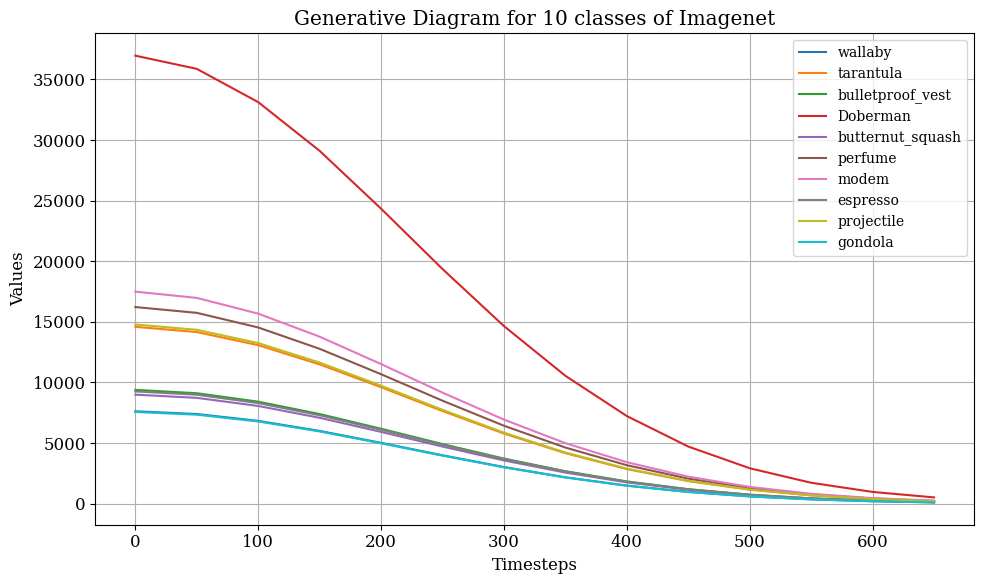

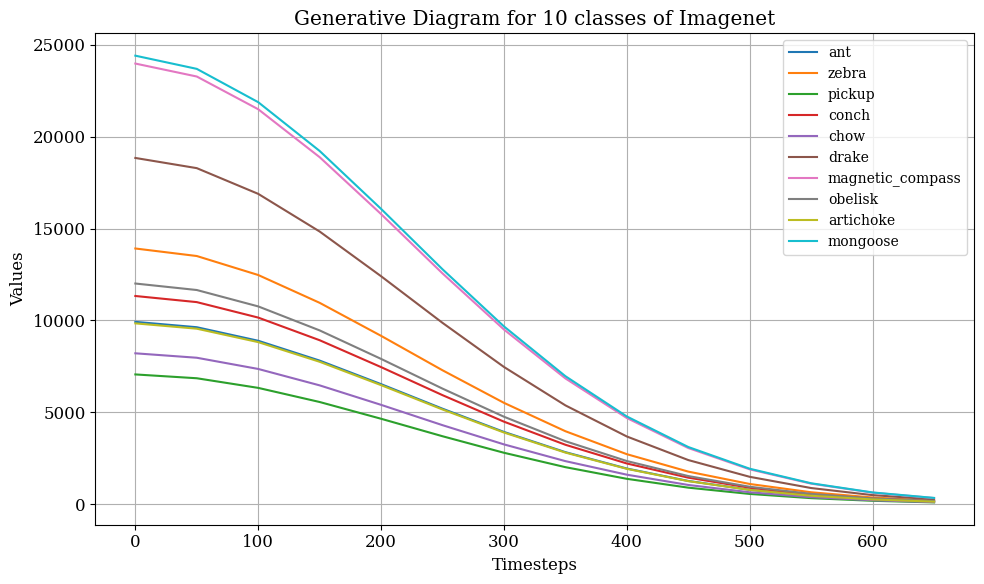

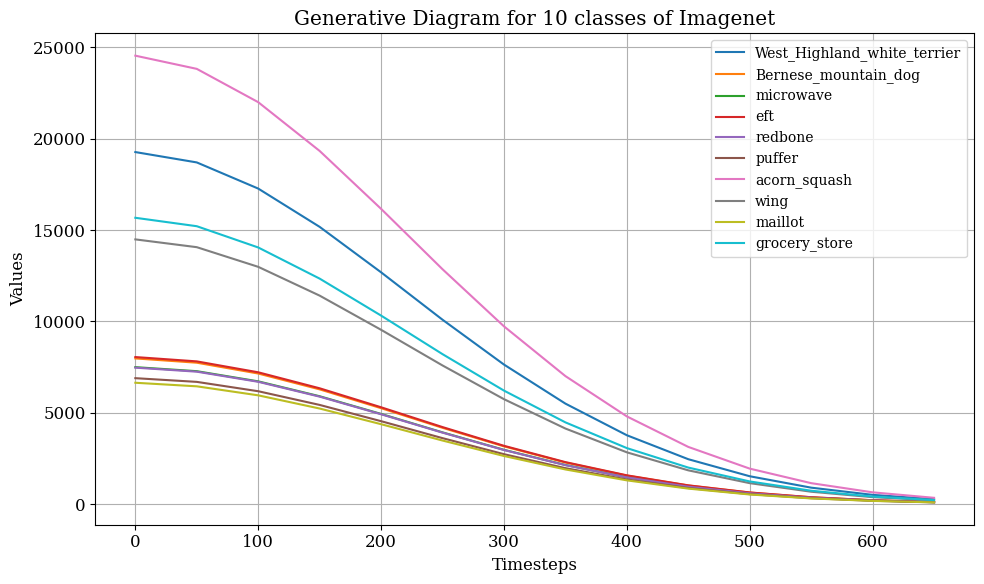

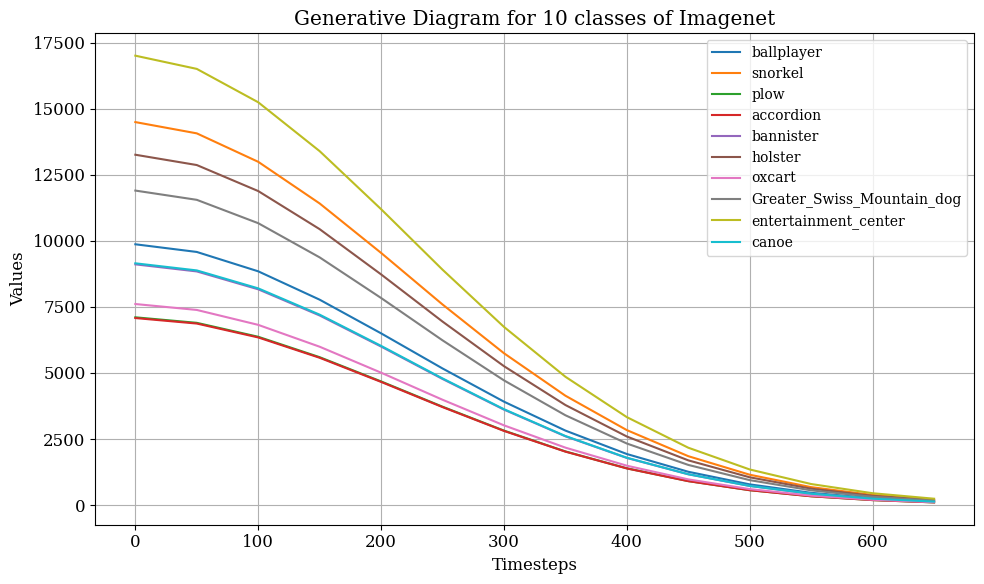

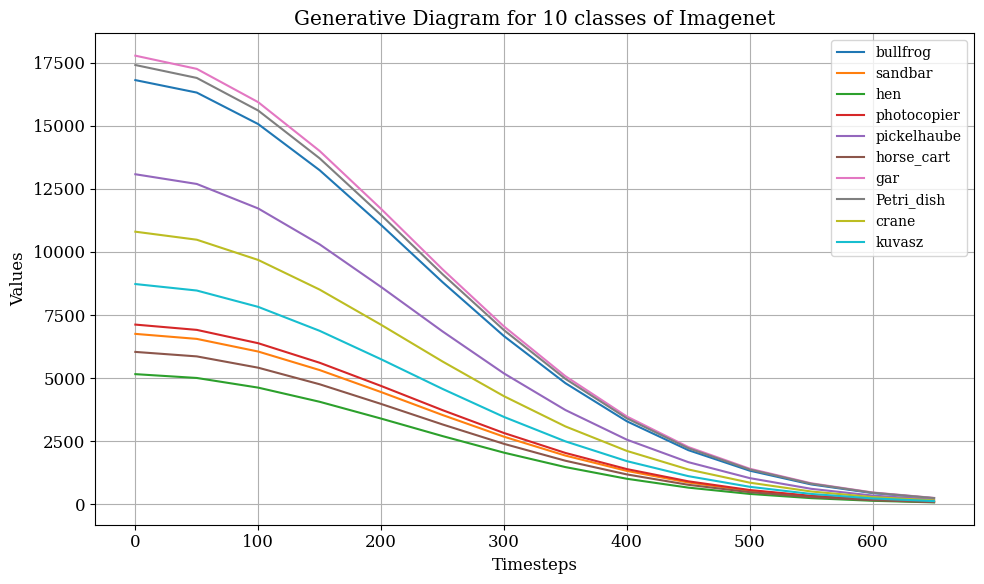

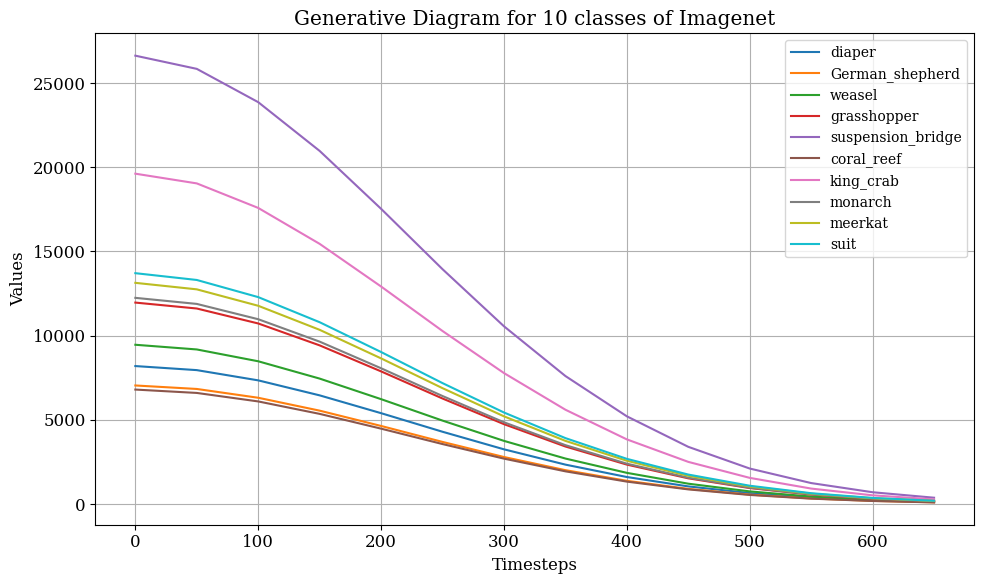

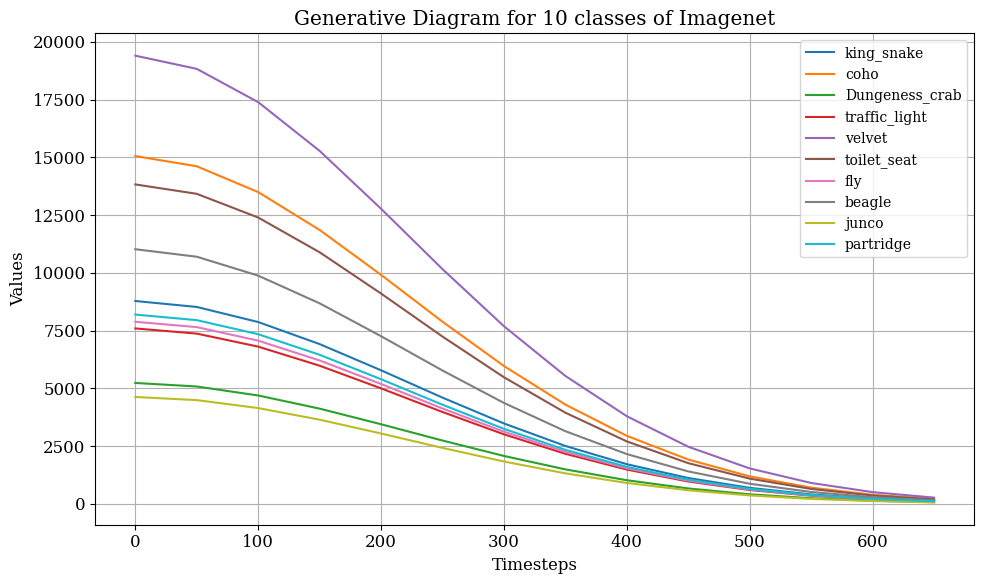

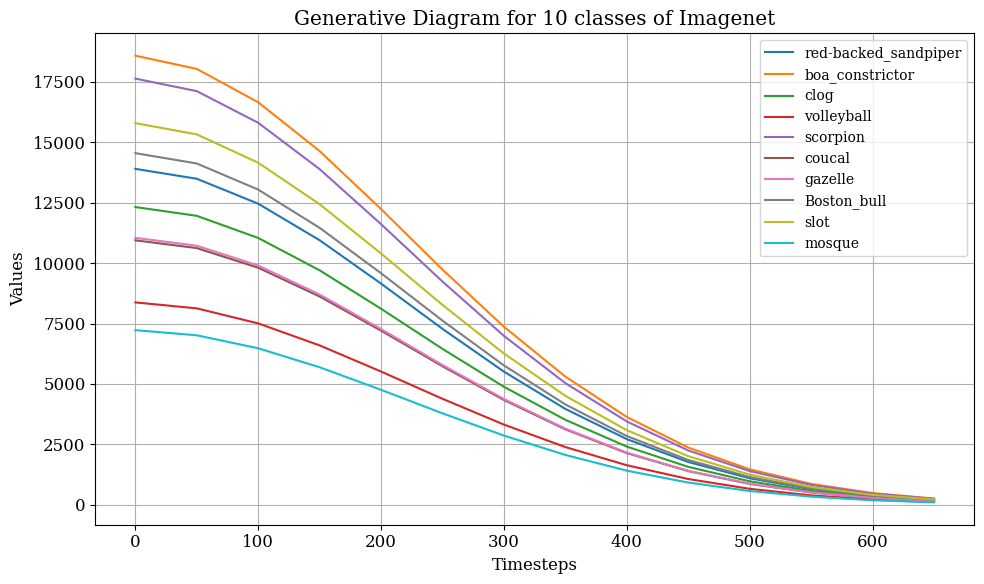

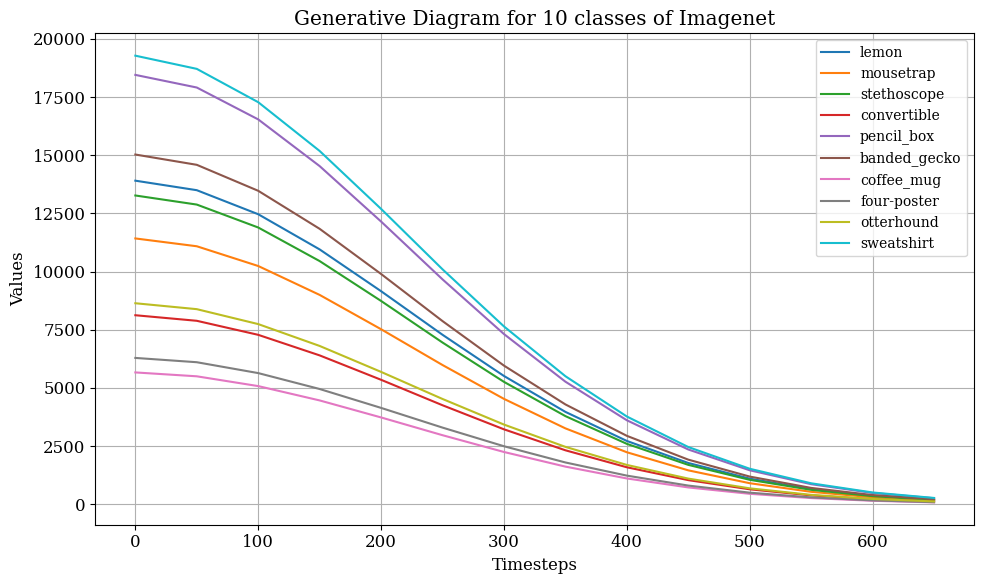

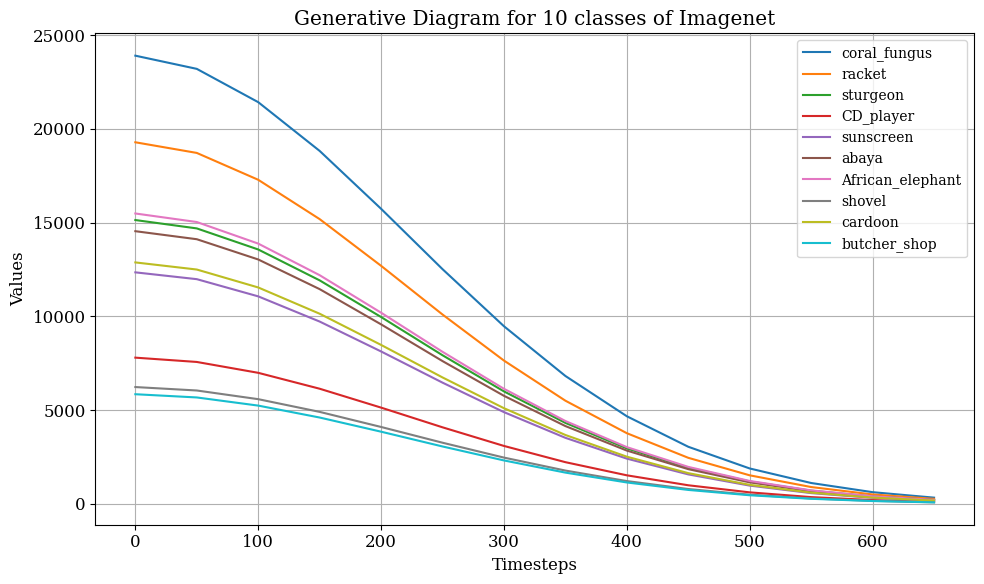

In [40]:
for i in range(0,100,10):
  timesteps = list(range(0, 700, 50))

  # Create the plot
  plt.figure(figsize=(10, 6))  # Adjust figure size as needed

  # Plot each class's data
  for label in list(list_labels)[i:i+10]:
    val_t = values_dct[label]
    plt.plot(timesteps, np.array([val.item() for val in val_t]), label=label)  # Label each line
  # Customize the plot
  plt.xlabel("Timesteps")
  plt.ylabel("Values")
  plt.title("Generative Diagram for 10 classes of Imagenet")
  plt.legend(fontsize='small')  # Show the legend with class names

  # Apply ICML-like style elements
  plt.tight_layout()
  plt.rcParams['font.family'] = 'serif'
  plt.rcParams['font.size'] = 12
  plt.grid(True)  # Add a grid

  # Display the plot
  plt.savefig(f"imagenet_10_gen_diag_{(i//10)+1}.pdf", format="pdf", bbox_inches="tight")

  plt.show()

